# Blah Blah Blah
*By Kuanlin Chen, PhD student of the schulman lab*

*Advisor: Rebecca Schulman, PhD*

*Johns Hopkins University*

Blah Blah Blah

In [1]:
# Package Importing
import csv, math, os, time, copy, matplotlib, datetime, keras

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import io as spio
from scipy.ndimage import gaussian_filter
from scipy.stats import bernoulli

from math import log10, floor

from skimage import transform, exposure

print(keras.__version__) # 2.4.3
print(tf.__version__) # 2.2.0

2.4.3
2.2.0


#### Set Up Material Simulation Environment

2.4.3
2.2.0


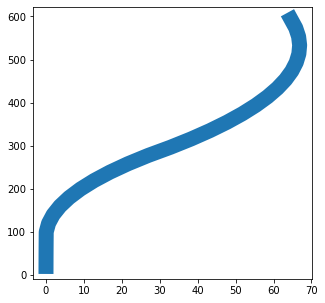

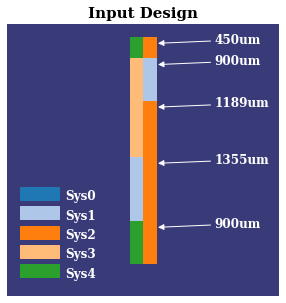

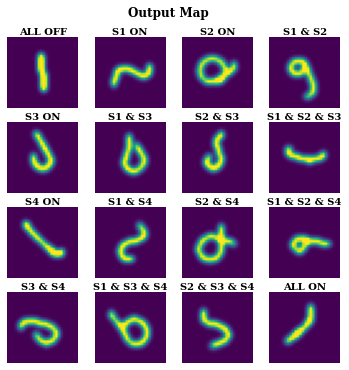

In [2]:
%run ./Numeric_Simulation_of_Material_Behavior_indev.ipynb

In [3]:
# Sample random design
# max_seg = 7
# segment_lengths_ex_four_types = np.random.random(size = (max_seg,)) * 500 + 600
# segment_identities_ex_four_types = np.random.randint(0, high=(4 + 1),size = (2, max_seg))
# print(segment_lengths_ex_four_types)
# print(segment_identities_ex_four_types)

# Sample Design
# 447.00237374  907.26817329 1176.51880725 1355.23921038  894.26759248]
segment_lengths_ex_four_types = [938, 954, 1022, 843, 931, 722, 702, 655, 1066, 947]
segment_identities_ex_four_types = [[2,3,2,3,2,3,4,0,1,4],[4,4,3,1,3,4,4,1,3,2]]
b = ActuatorStrip(segment_lengths_ex_four_types, segment_identities_ex_four_types, four_t_rocs, four_t_ctls)
# a.generate_curves()

# set model for classification
# CNN_dig_v1,  CNN_dig_RSQ2_v1
# a.plot_input_design(save = True)
# print("In the beginning, we started with MNIST trained CNN, but has low accuracy.")
# cnn_digit_model = load_model("CNN_dig_v1.h5")
# a.plot_output_map(score = True, save = False)
# print("We later added strip data to improve accuracy and enable random squiggle identification.")

# cnn_digit_model = load_model("CNN_dig_v1.h5")
# a.plot_input_design(save = False)
# a.plot_output_map(score = False, save = False)
# a.plot_output_map(score = True, save = False)
# print("We further increased the searching space vi`a rotation and mirroring")
# a.plot_input_and_all(rotation = 10, save = False)
# a.plot_input_and_selected(rotation = 20, save = False)
cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")

In [4]:
def result_visualizer(result):
    datalist = result.replace("[","",6).replace("]","",6).split()
    Segments = 0;  Identities = 0; sl = [];
    
    for i in datalist:
        if i == 'Segments:': Segments = 1
        elif i == 'Identities:': Segments = 0; Identities = 1; idts = np.zeros(shape = (2, len(sl)), dtype = int)
        elif i == 'Formed:': Identities = 0
        elif Identities > len(sl):
            idts[1][Identities-1-len(sl)] = i; Identities += 1
        elif Identities:
            idts[0][Identities-1] = i; Identities += 1
        if Segments and i != 'Segments:': sl.append(float(i))
    s1 = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)
    return s1



In [5]:
def ultimate_plotter(teststrip, digit_order, rotate_angle, score_index,\
                     test = False, save = False):
    teststrip.generate_curves()
    shiftlist = [5,5,5,5,9,9,9,9,13,13,13,13,17,17,17,17]
    statelist = ["ALL OFF", "S1 ON", "S2 ON", "S1 & S2",
                 "S3 ON", "S1 & S3", "S2 & S3", "S1 & S2 & S3",
                 "S4 ON", "S1 & S4", "S2 & S4", "S1 & S2 & S4",
                 "S3 & S4", "S1 & S3 & S4", "S2 & S3 & S4", "ALL ON"]
    fig = plt.figure(figsize = (12, 6))
    ax = plt.subplot(1, 2, 1)
    if not test:
        fig_width = int(np.sum(teststrip.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        cm = plt.cm.get_cmap('tab20')
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(teststrip.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(teststrip.segment_lengths[0:i])),strip_width,teststrip.segment_lengths[i], color = cm.colors[teststrip.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(teststrip.segment_lengths[0:i])),strip_width,teststrip.segment_lengths[i], color = cm.colors[teststrip.identities[1][i]]))

        ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

        ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 12, color = "white", family = "serif", weight = "bold")

        for i in range(len(teststrip.segment_lengths)):
            ax.annotate("%dum"%(teststrip.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(teststrip.segment_lengths[0:i])), xytext=(fig_width-strip_width*5, strip_width*1.5+np.sum(teststrip.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 12, color = "white", family = "serif", weight = "bold")
        plt.title("Input Design", fontsize = 15, family = "serif", weight = "bold")
        plt.axis(False)

    ctr = 0; 
    for i in range(16):
        ax = plt.subplot(4, 8, ctr + shiftlist[ctr])
        curve = teststrip.curves[digit_order[i]]; curve.rotate(rotate_angle[i]*math.pi/180)
        img = curve.generate_image(filter = 'Gaussian')
        plt.imshow(img)
        plt.title(statelist[digit_order[i]], fontsize = 10, family = "serif", weight = "bold", y = .95)
        if i < 10:
            plt.plot(range(28),[0]*28, lw = 4, color = "#ffdf2b")
            plt.plot(range(28),[27]*28, lw = 4, color = "#ffdf2b")
            plt.plot([0]*28,range(28), lw = 4, color = "#ffdf2b")
            plt.plot([27]*28,range(28), lw = 4, color = "#ffdf2b")
        scores = cnn_digit_model.predict(img.reshape(1,28,28,1))[0]    
        plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(np.argsort(scores)[-score_index[i]], np.sort(scores)[-score_index[i]]), fontsize = 9, family = "serif", weight = "bold", color = "white")
        plt.axis(False); ctr += 1
    fig.suptitle("Design Input and Output Map", fontsize = 15, family = "serif", weight = "bold", y = .95)
    if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "_inandoutput.png", dpi = 600)
    plt.show()

In [6]:
import cv2

def imflatfield(I, sigma):
    """
    Python equivalent imflatfield implementation
    I format must be BGR and type of I must be uint8
    """
    
    A = I.astype(np.float32) / 255  # A = im2single(I);
    Ihsv = cv2.cvtColor(A, cv2.COLOR_RGB2HSV)  # Ihsv = rgb2hsv(A);
    A = Ihsv[:, :, 2]  # A = Ihsv(:,:,3);

    filterSize = int(2 * np.ceil(2 * sigma) + 1);  # filterSize = 2*ceil(2*sigma)+1;

    # shading = imgaussfilt(A, sigma, 'Padding', 'symmetric', 'FilterSize', filterSize); % Calculate shading
    shading = cv2.GaussianBlur(A, (filterSize, filterSize), sigma, borderType = cv2.BORDER_REFLECT)

    meanVal = np.mean(A)  # meanVal = mean(A(:),'omitnan')

    #% Limit minimum to 1e-6 instead of testing using isnan and isinf after division.
    shading = np.maximum(shading, 1e-6)  # shading = max(shading, 1e-6);

    B = A * meanVal / shading  # B = A*meanVal./shading;

    #% Put processed V channel back into HSV image, convert to RGB
    Ihsv[:, :, 2] = B  # Ihsv(:,:,3) = B;

    B = cv2.cvtColor(Ihsv, cv2.COLOR_HSV2RGB)  # B = hsv2rgb(Ihsv);

    B = np.round(np.clip(B*255, 0, 255)).astype(np.uint8)  # B = im2uint8(B);

    return B

def image_flat_field(img, sigma = 30):
    
    out2 = imflatfield(img, sigma)

    # Conver out2 to float32 before converting to LAB
    out2 = out2.astype(np.float32) / 255  # out2 = im2single(out2);

    shadow_lab = cv2.cvtColor(out2, cv2.COLOR_BGR2Lab)  # shadow_lab = rgb2lab(out2);

    max_luminosity = 100
    L = shadow_lab[:, :, 0] / max_luminosity  # L = shadow_lab(:,:,1)/max_luminosity;

    shadow_adapthisteq = shadow_lab.copy() # shadow_adapthisteq = shadow_lab;

    # shadow_adapthisteq(:,:,1) = adapthisteq(L)*max_luminosity;
    clahe = cv2.createCLAHE(clipLimit=20, tileGridSize=(8,8))
    cl1 = clahe.apply((L*(2**16-1)).astype(np.uint16)) # CLAHE in OpenCV does not support float32 (convert to uint16 and back).
    shadow_adapthisteq[:, :, 0] = cl1.astype(np.float32) * max_luminosity / (2**16-1)

    shadow_adapthisteq = cv2.cvtColor(shadow_adapthisteq, cv2.COLOR_Lab2BGR) # shadow_adapthisteq = lab2rgb(shadow_adapthisteq);

    # Convert shadow_adapthisteq to uint8
    shadow_adapthisteq = np.round(np.clip(shadow_adapthisteq*255, 0, 255)).astype(np.uint8)  # B = im2uint8(B);
    
    return shadow_adapthisteq




## Even

In [7]:
idts = [[4, 1, 4, 4, 4],[2, 2, 3, 2, 2]]
sl = [1653, 1606, 1412, 1769, 1013]

cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")
teststrip = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)

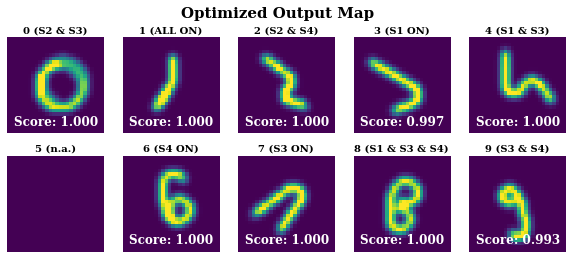

In [8]:
teststrip.plot_selected_output_map()

## Odd

In [9]:
idts = [[1, 2, 1, 3, 1],[2, 4, 2, 2, 2]]
sl = [1898, 1138, 1635, 1069, 1199]

cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")
teststrip = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)

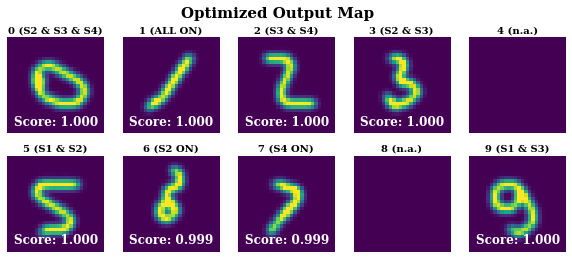

In [10]:
teststrip.plot_selected_output_map()

## Six Seg

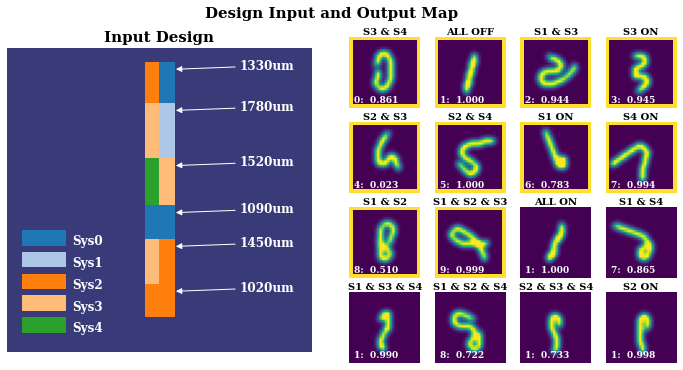

In [12]:
# perfect
idts = [[2,3,4,0,3,2],[0,1,3,0,2,2]]
sl = [1330, 1780, 1520, 1090, 1450, 1020]
cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")
teststrip = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)
# teststrip.plot_output_map(score = False, save = False)
#                0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15
digit_order =  [12,  0,  5,  4,  6, 10,  1,  8,  3,  7, 15,  9, 13, 11, 14,  2]
rotate_angle = [ 0,  0,-30,140,190,-80, 90,180, 50,280,  0,  0,200,  0,180,180]
score_index =  [ 1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]
    
ultimate_plotter(teststrip, digit_order, rotate_angle, score_index,\
                 test = False, save = False)

